In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from rf_classification import get_data

In [2]:
class AdaBoost:
  def __init__(self, M):
    self.M = M

  def fit(self, X, Y):
    self.models = []
    self.alphas = []

    N, _ = X.shape
    W = np.ones(N) / N

    for m in range(self.M):
      tree = DecisionTreeClassifier(max_depth=1)
      tree.fit(X, Y, sample_weight=W)
      P = tree.predict(X)

      err = W.dot(P != Y)
      alpha = 0.5*(np.log(1 - err) - np.log(err))

      W = W*np.exp(-alpha*Y*P) # vectorized form
      W = W / W.sum() # normalize so it sums to 1

      self.models.append(tree)
      self.alphas.append(alpha)

  def predict(self, X):
    # NOT like SKLearn API
    # we want accuracy and exponential loss for plotting purposes
    N, _ = X.shape
    FX = np.zeros(N)
    for alpha, tree in zip(self.alphas, self.models):
      FX += alpha*tree.predict(X)
    return np.sign(FX), FX

  def score(self, X, Y):
    # NOT like SKLearn API
    # we want accuracy and exponential loss for plotting purposes
    P, FX = self.predict(X)
    L = np.exp(-Y*FX).mean()
    return np.mean(P == Y), L


dimensionality: 139
20
40
60
80
100
120
140
160
180
final train error: 0.0
final test error: 0.0


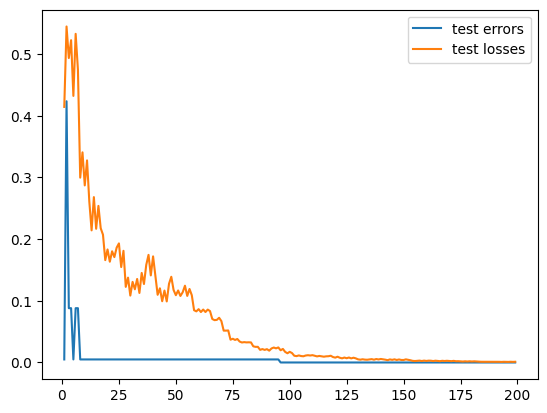

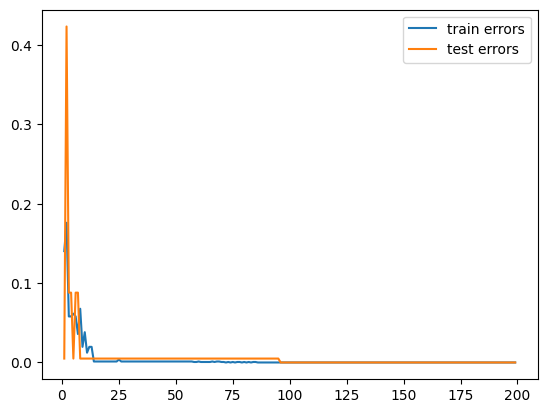

In [3]:
if __name__ == '__main__':
    
  X, Y = get_data()
  Y[Y == 0] = -1 # make the targets -1,+1
  Ntrain = int(0.8*len(X))
  Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
  Xtest, Ytest = X[Ntrain:], Y[Ntrain:]

  T = 200
  train_errors = np.empty(T)
  test_losses = np.empty(T)
  test_errors = np.empty(T)
  for num_trees in range(T):
    if num_trees == 0:
      train_errors[num_trees] = None
      test_errors[num_trees] = None
      test_losses[num_trees] = None
      continue
    if num_trees % 20 == 0:
      print(num_trees)

    model = AdaBoost(num_trees)
    model.fit(Xtrain, Ytrain)
    acc, loss = model.score(Xtest, Ytest)
    acc_train, _ = model.score(Xtrain, Ytrain)
    train_errors[num_trees] = 1 - acc_train
    test_errors[num_trees] = 1 - acc
    test_losses[num_trees] = loss

    if num_trees == T - 1:
      print("final train error:", 1 - acc_train)
      print("final test error:", 1 - acc)

  plt.plot(test_errors, label='test errors')
  plt.plot(test_losses, label='test losses')
  plt.legend()
  plt.show()

  plt.plot(train_errors, label='train errors')
  plt.plot(test_errors, label='test errors')
  plt.legend()
  plt.show()
